# Uncertainty Analisis of BNNs for Post-Hoc calibration

In [35]:
import os
import sys
import time

import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import entropy, gaussian_kde
from torch.nn.functional import softmax as torch_softmax

from adaptive_tempscaling.models import TempScaling
from adaptive_tempscaling.bnn_models import BNN_GVILR
from adaptive_tempscaling.bayesian_models import BayesianTempScaling_N
from adaptive_tempscaling.utils import load_precomputedlogits, compare_results, mutual_info

In [22]:
def save_calibrator(dataset,
                    model,
                    calibrator,
                    history=None,
                    name='calibrator',
                    save_path='../../trained_models'):
    # Build path.
    key = '_'.join([model, dataset])
    path = os.path.join(save_path, key)

    os.makedirs(path, exist_ok=True)

    torch.save(calibrator.state_dict(), os.path.join(path, name + '.pth'))

    if history is not None:
        np.save(os.path.join(path, name + '.npy'), history)


def load_calibrator(dataset,
                    model,
                    history=False,
                    name='calibrator',
                    save_path='../../trained_models'):
    # Build path.
    key = '_'.join([model, dataset])
    path = os.path.join(save_path, key)

    calibrator_state_dict = torch.load(os.path.join(path, name + '.pth'), weights_only=True)

    if history is True and os.path.isfile(os.path.join(path, name + '.npy')):
        h = np.load(os.path.join(path, name + '.npy'), allow_pickle=True).item()
        return calibrator_state_dict, h

    return calibrator_state_dict

## Data

In [3]:
DATASET = 'cars'
MODEL = 'resnet-18'
dev = torch.device('mps')

In [4]:
train, validation, test = load_precomputedlogits(dataset=DATASET, model=MODEL, data_path='../../data', to_tensor=True)

X_train, Y_train = train
X_val, Y_val = validation
X_test, Y_test = test

N, dim = X_train.shape

## Baselines

In [5]:
### Base Temp-Scaling
tempScaler = TempScaling()
tempScaler.fit(X_val, Y_val, v=True);

In [6]:
### Bayesian Temp-Scaling
bayes_TS = BayesianTempScaling_N()
h = bayes_TS.fit(X_val, Y_val, epochs=10000, batch_size=X_val.shape[0], MC_samples=50, lr=1e-4, warm_up=0, v=True);

In [7]:
save_calibrator(dataset=DATASET, model=MODEL, calibrator=bayes_TS, name='bayes_TS')

In [23]:
bayes_TS = BayesianTempScaling_N()
bayes_TS.load_state_dict(load_calibrator(dataset=DATASET, model=MODEL, name='bayes_TS', save_path='../trained_models'))

<All keys matched successfully>

In [41]:
log_iT = bayes_TS.iT_mean \
            + torch.randn((1000, *bayes_TS.iT_mean.size()))*torch.sqrt(torch.exp(bayes_TS.iT_log_var))

samples = bayes_TS.iTransform(log_iT)

In [42]:
samples.size()

torch.Size([1000, 1])

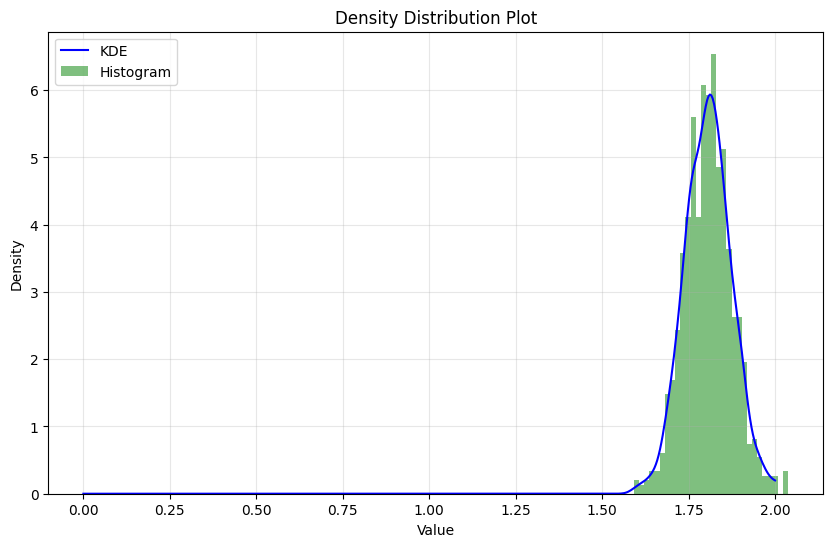

In [43]:
data = 1/samples.detach().numpy().flatten()

# Calculate the kernel density estimation
kde = gaussian_kde(data)
x_range = np.linspace(0, 2, 500)
y_values = kde(x_range)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, y_values, 'b-', label='KDE')
plt.hist(data, bins=30, density=True, alpha=0.5, color='g', label='Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Distribution Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

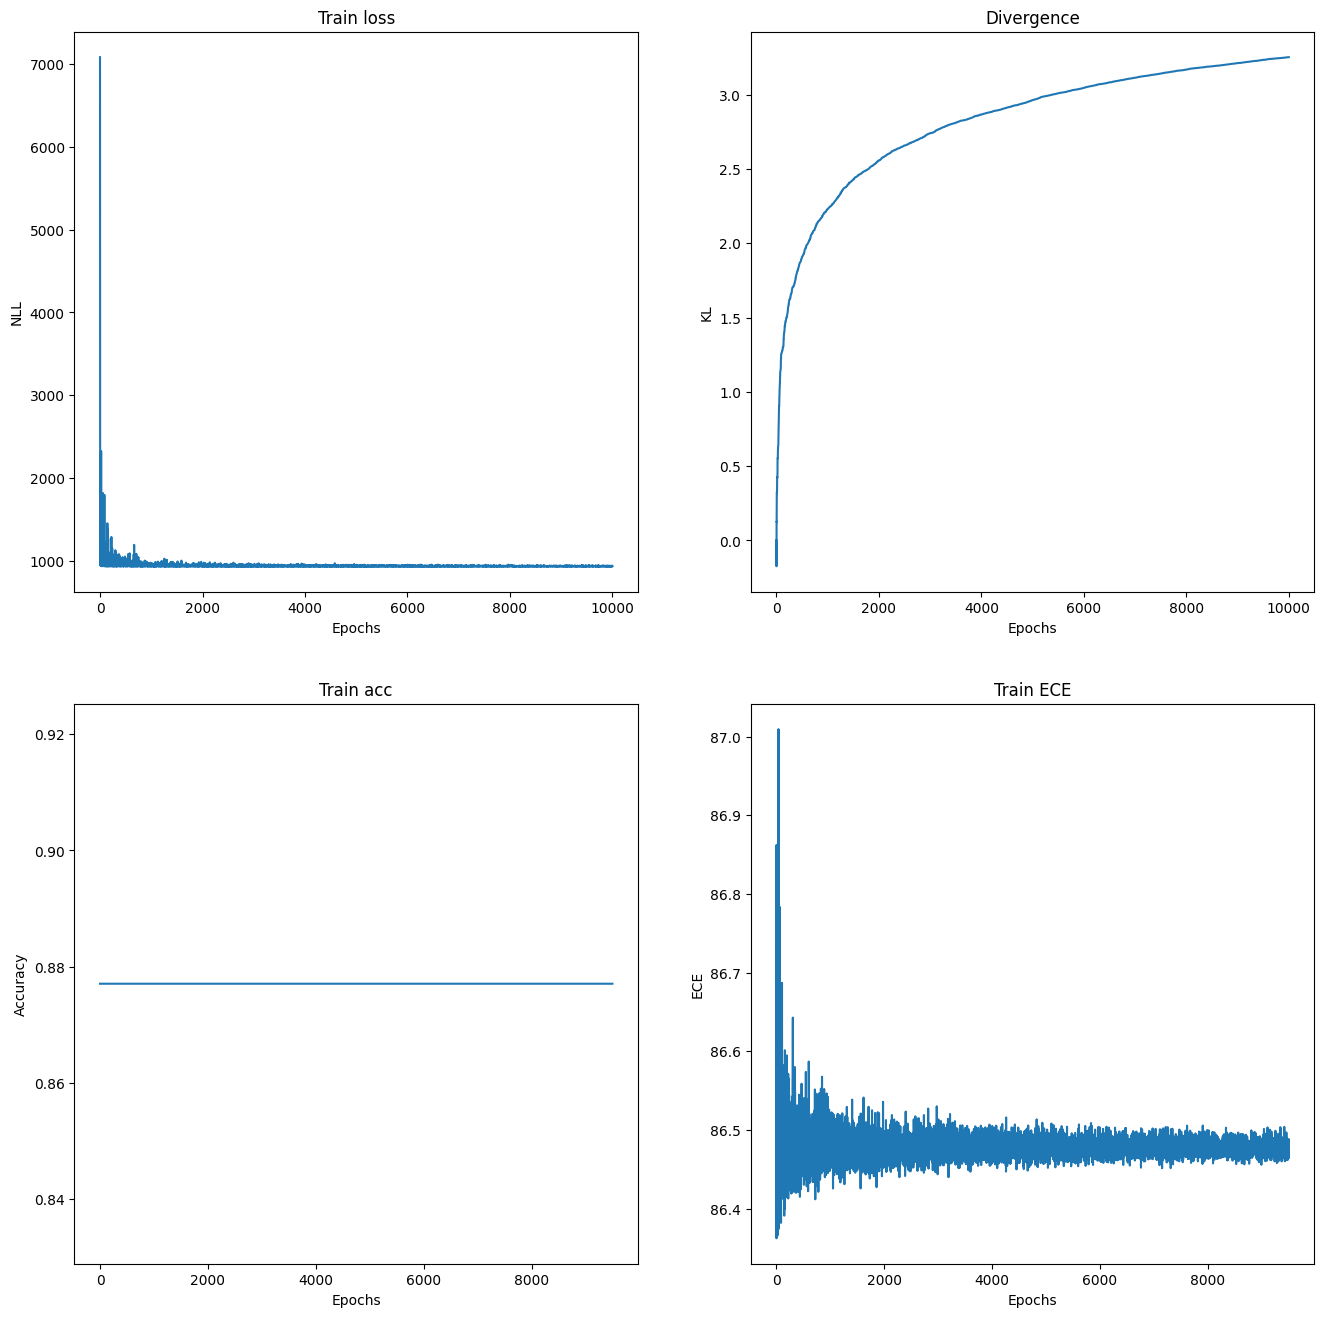

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

ax[0, 0].plot(h['nll'])
ax[0, 0].set_title('Train loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('NLL')

ax[0, 1].plot(h['divergence'])
ax[0, 1].set_title('Divergence')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('KL')

ax[1, 0].plot(h['acc'])
ax[1, 0].set_title('Train acc')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Accuracy')

ax[1, 1].plot(h['ece'])
ax[1, 1].set_title('Train ECE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('ECE')

plt.show();

In [25]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': torch_softmax(X_test, dim=1),
                             'TempScal': tempScaler.predictive(X_test),
                             'Bayesian-TS': bayes_TS.predictive(X_test)}, target=Y_test, M=15, from_logits=False);

##### Results on test set:
  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                86.56%         7.00%        24.05%    2.075e-01     6.335e-01
TempScal             86.56%         1.54%         7.65%    1.945e-01     4.921e-01
Bayesian-TS          86.56%         1.66%        10.20%    1.944e-01     4.927e-01


## Analysis of Mutual Information with Bayesian Temp-Scaling VI

In [26]:
preds_train = bayes_TS.predictive(X_train.cpu(), n_samples=50, return_list=True)
preds_val = bayes_TS.predictive(X_val.cpu(), n_samples=50, return_list=True)
preds_test = bayes_TS.predictive(X_test.cpu(), n_samples=1000, return_list=True)

mean_preds_train = torch.mean(preds_train, dim=1)
mean_preds_val = torch.mean(preds_val, dim=1)
mean_preds_test = torch.mean(preds_test, dim=1)

In [27]:
MI, H = mutual_info(preds_test)
MI_val, H_val = mutual_info(preds_val)
MI_train, H_train = mutual_info(preds_train)

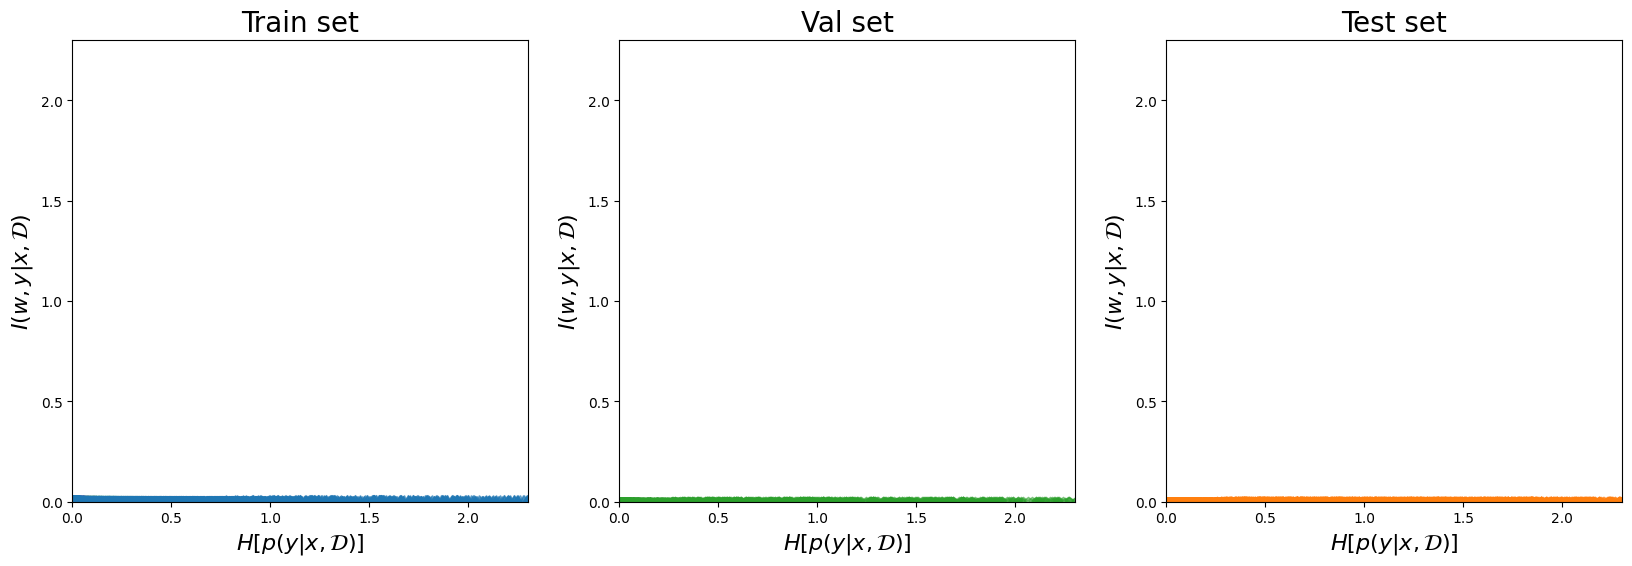

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].scatter(H_train, MI_train, marker='d', alpha=0.5)
ax[0].set_xlim(0, np.log(10))
ax[0].set_ylim(0, np.log(10))
ax[0].set_xlabel('$H[p(y|x, \mathcal{D})]$', fontsize=16)
ax[0].set_ylabel('$I(w, y | x, \mathcal{D})$', fontsize=16)
ax[0].set_title('Train set', fontsize=20)


ax[1].scatter(H_val, MI_val, marker='p', c='tab:green', alpha=0.5)
ax[1].set_xlim(0, np.log(10))
ax[1].set_ylim(0, np.log(10))
ax[1].set_xlabel('$H[p(y|x, \mathcal{D})]$', fontsize=16)
ax[1].set_ylabel('$I(w, y | x, \mathcal{D})$', fontsize=16)
ax[1].set_title('Val set', fontsize=20)

ax[2].scatter(H, MI, marker='p', c='tab:orange', alpha=0.5)
ax[2].set_xlim(0, np.log(10))
ax[2].set_ylim(0, np.log(10))
ax[2].set_xlabel('$H[p(y|x, \mathcal{D})]$', fontsize=16)
ax[2].set_ylabel('$I(w, y | x, \mathcal{D})$', fontsize=16)
ax[2].set_title('Test set', fontsize=20)

plt.show()

### Train BNN

In [18]:
D = 'KL'
hidden_size = []
best_beta = 1
best_K = 1000

bnn = BNN_GVILR(dim, dim,pmean=torch.Tensor([0.0]), plog_var=torch.Tensor([0.0]), hidden_size=hidden_size)

In [21]:
bnn.to(dev);
h_best = bnn.fit(X_train.to(dev), Y_train.to(dev), beta=best_beta, epochs=5000, batch_size=1000, MC_samples=50, lr=1e-3, warm_up=5, v=True);
bnn.cpu();


On epoch: 4, NLL: 4.672e+05, D: 1.842e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 14.86s
On epoch: 9, NLL: 4.055e+05, D: 1.830e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 29.74s
On epoch: 14, NLL: 3.428e+05, D: 1.818e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 44.50s
On epoch: 19, NLL: 2.928e+05, D: 1.807e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 60.22s
On epoch: 24, NLL: 2.614e+05, D: 1.797e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 77.74s
On epoch: 29, NLL: 2.226e+05, D: 1.786e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 98.07s
On epoch: 34, NLL: 1.988e+05, D: 1.777e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 119.22s
On epoch: 39, NLL: 1.727e+05, D: 1.767e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 140.60s
On epoch: 44, NLL: 1.581e+05, D: 1.757e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at time: 160.73s
On epoch: 49, NLL: 1.394e+05, D: 1.748e+05, collapsed: 0.000%, KL-collapsed: 0.000%, at ti

KeyboardInterrupt: 

In [ ]:
save_calibrator(dataset=DATASET, model=MODEL, calibrator=bnn, name='bnn[]b1', save_path='../../trained_models')

In [ ]:
bnn = load_calibrator(dataset=DATASET, model=MODEL, name='bnn[]b1', save_path='../../trained_models')